# Анализ точек роста бизнеса сервиса аренды самокатов

**Описание проекта**\
Изучение данных о клиентах сервиса проката самокатов и данных об их потребительском поведении.\
Проверка ряда гипотез.

**Цель**\
Определить потенциальные точки роста бизнеса компании.

**План**
- Изучить предоставленные данные, проверсти их предобработку.
- Проверсти анализ текущей маркетинговой ситуации.
- Проверить ряд гипотез (с применением t-test), призванных определить точки роста сервиса проката самокатов.

**Исходные данные**\
Информация о позьзовании услугами сервиса за один календарный год клиентами из восьми городов.\
Имеются три датасета:
- Данные о пользователях - id, возраст, город, тип тарифного плана.
- Данные о поездках - дата, расстояние, продолжительность.
- Параметры тарифных планов.

## Загрузка данных и изучение качества данных

In [4]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

# Отображение вывода в той же ячейке
%matplotlib inline

# глобальный формат для десятичных дробей
pd.options.display.float_format = '{:.2f}'.format

In [5]:
try:
    rides_raw = pd.read_csv('rides_go.csv')
except:
    rides_raw = pd.read_csv('/datasets/rides_go.csv')
try:
    subscriptions_raw = pd.read_csv('subscriptions_go.csv')
except:
    subscriptions_raw = pd.read_csv('/datasets/subscriptions_go.csv')
try:
    users_raw = pd.read_csv('users_go.csv')
except:
    users_raw = pd.read_csv('/datasets/users_go.csv')

In [6]:
# Смотрим исходные датасеты
display (rides_raw.head(3))
display (subscriptions_raw.head(5))
display (users_raw.head(3))

,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra


In [7]:
# Смотрим состав данных датасетов
print (rides_raw.info())
print ('')
print (subscriptions_raw.info())
print ('')
users_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count 

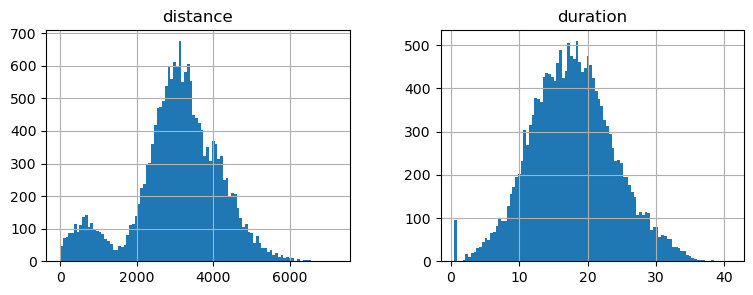

In [8]:
# Проверяем наличие выбросов в столбцах distance и duration в rides
rides_raw[['distance', 'duration']].hist(bins=100, figsize=(9, 3))
plt.show()

Обращает на себя внимание пик  в duration в районе меньше 1 минуты.\
**В дальнейшем проверим, есть ли он во всех городах**,\
и примем решение, что с ним делать.

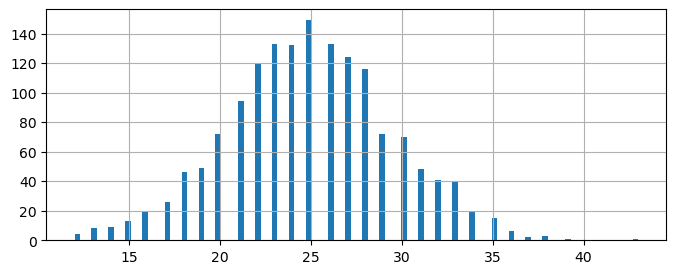

In [10]:
# Проверяем наличие выбросов в столбце age в users
users_raw['age'].hist(bins=100,figsize=(8, 3))
plt.show()

In [11]:
# Проверяем наличие полных дубликатов в датасетах rides и users. В датасете subscriptions дубликатов нет.

duplicated_rides_raw = rides_raw.duplicated().sum()
display(f"Количество полных дубликатов в таблице rides: {duplicated_rides_raw}")
duplicated_users_raw = users_raw.duplicated().sum()
display(f"Количество полных дубликатов в таблице users: {duplicated_users_raw}")

'Количество полных дубликатов в таблице rides: 0'

'Количество полных дубликатов в таблице users: 31'

In [12]:
# Смотрим состав строк-полных дубликатов
#display(users_raw[users_raw.duplicated()])

In [13]:
# Проверяем наличие скрытых дубликатов в сторбце city. В других столбцах скрытые дубликаты маловерочтны.
users_raw ['city'].unique ()
#users_raw ['city'].value_counts()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

**Результат предварительной проверки данных**:
- Пропущенных данных в датасетах нет.
- Выбросов, которые стоило бы удалить, в проверенных столбцах нет.
- Скрытых дубликатов в столбце city нет.\
  В других полях критичные скрытые дубликаты маловероятны.
- Есть 31 строка-дубликат в датасете users.\
  Удалим их на этапе предобработки данных

## Предобработка данных

In [16]:
# Для обработанных данных для удобства вводим новые переменные и дальше работаем с ними.
subscriptions = subscriptions_raw.copy()
rides = rides_raw.copy()

- Удаляем 31 строку-дубликат в датасете users.
- Меняем даты на формат danetime.
- Создаём столбец month с номером месяца на основе дат.

In [18]:
# Осуществляем запланированные действия по предобработке.
# Меняем формат даты
rides['date'] = pd.to_datetime(rides['date']).dt.normalize()

# Добавляем столбец month
rides['month'] = rides['date'].dt.month

# Удаляем дубликаты в users
users = users_raw.drop_duplicates().reset_index(drop=True)

Проверяем результат предобработки

In [20]:
# Проверяем результат

display(rides.head(3))
print (rides.info())
print ('')
print (users.info())

,user_id,distance,duration,date,month
0,1,4409.92,25.60,2021-01-01,1
1,1,2617.59,15.82,2021-01-18,1
2,1,754.16,6.23,2021-04-20,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.1+ 

In [21]:
# Проверяем, за один ли год данные
print (f"Данные представлены за  {rides['date'].dt.year.unique()}  год")
# Проверяем, за сколько месяцев данные
print (f"Данные представлены за  {rides['month'].nunique()}  месяцев")

Данные представлены за  [2021]  год
Данные представлены за  12  месяцев


**Результат предобработки**
- Удалены 31 строка-дубликат в датасете users. Что составляет 1,98 % данных. 
- Изменён формат даты на формат danetime.
- Создан столбец momnh с номером месяца на основе дат.
- После изменения формата проверен диапазон дат, за который есть данные. 

## Исследовательский анализ данных
**Общая информация о пользователях и поездках**

### Частота встречаемости городов

,user_id,%_from_total
city,,
Пятигорск,219,14.28
Екатеринбург,204,13.30
Ростов-на-Дону,198,12.91
Краснодар,193,12.58
Сочи,189,12.32
Омск,183,11.93
Тюмень,180,11.73
Москва,168,10.95


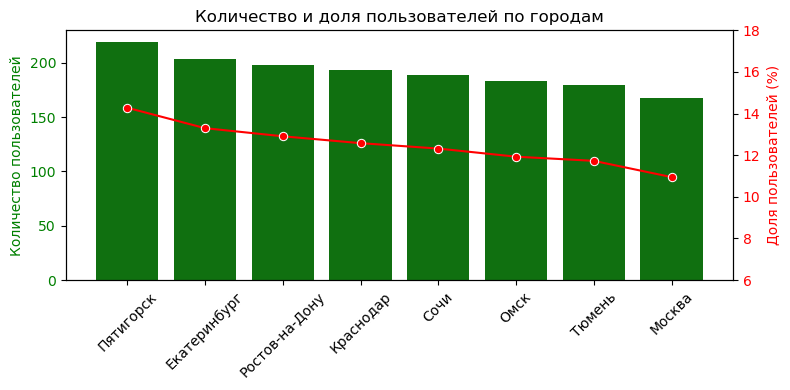

In [25]:
# Строим таблицу количества пользователей по городам
count_id_cities = users.pivot_table(index='city', values=['user_id'], aggfunc={'user_id': 'count'})

# Вычисляем долю города в общем количестве
total_per_user_id = count_id_cities['user_id'].sum()
count_id_cities['%_from_total'] = round (((count_id_cities['user_id'] / total_per_user_id) *100),2)

# Сортируем данные по количеству пользователей по убыванию (по оси Y1)
count_id_cities = count_id_cities.sort_values(by='user_id', ascending=False)

# Создаем фигуру и оси
fig, ax1 = plt.subplots(figsize=(8, 4))

# Строим первый график - количество пользователей по городам
sns.barplot(x=count_id_cities.index, y=count_id_cities['user_id'], ax=ax1, color='g')
ax1.set_ylabel('Количество пользователей', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# строим вторую ось Y2 для доли пользователей
ax2 = ax1.twinx()
sns.lineplot(x=count_id_cities.index, y=count_id_cities['%_from_total'], ax=ax2, color='r', marker='o')
ax2.set_ylabel('Доля пользователей (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Настройка оси X
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
# Настраиваем диапазон значений для второй оси Y2, чтобы график был более плоским
ax2.set_ylim(6, 18)

plt.title('Количество и доля пользователей по городам')
plt.tight_layout()
display (count_id_cities)
plt.show()

**Наблюдения**

Чаще всего в системе регистрируются пользователи из Пятигорска (14.28 %), реже всего - из Москвы (10,95 %).\
Разница составляет 3,33 %. На первй взгляд, не много, но Москва по численности потенциальных пользователей в десятки раз больше Пятигорска. **Следовательно, положение Москвы по данному показателю очень низкое**.
>Возможно, это связано или с низкой доступностью сервиса в Москве, или с особенностями выборки.

### Соотношение пользователей с подпиской и без подписки

In [29]:
# ФУНКЦИЯ ГРУППИРОВКИ И СОРТИРОВКИ group_and_sort 
def group_and_sort(df, group_col1, group_col2=None, agg_col=None, agg_func='sum'):
    # Создаем сводную таблицу с группировкой
    if group_col2 is not None:
        # Группируем по двум столбцам, если group_col2 указан
        pivot_table = df.groupby([group_col1, group_col2])[agg_col].agg(agg_func).reset_index()
    else:
        # Группируем только по одному столбцу
        pivot_table = df.groupby([group_col1])[agg_col].agg(agg_func).reset_index()

    # Суммируем данные по group_col1, чтобы использовать для сортировки
    group_totals = pivot_table.groupby(group_col1)[agg_col].sum().reset_index()

    # Сортируем group_col1 по общему количеству агрегатных значений
    group_totals = group_totals.sort_values(by=agg_col, ascending=False)

    # Добавляем столбец с общим количеством для сортировки
    pivot_table['group_order'] = pivot_table[group_col1].map(group_totals.set_index(group_col1)[agg_col])

    # Если указана вторая группировка
    if group_col2 is not None:
        pivot_table = pivot_table.sort_values(by=['group_order', group_col2, agg_col], ascending=[False, True, False])
    else:
        pivot_table = pivot_table.sort_values(by=['group_order', agg_col], ascending=[False, False])

    # Удаляем временный столбец для сортировки
    pivot_table = pivot_table.drop(columns='group_order').reset_index(drop=True)

    return pivot_table

In [30]:
subscription_cities_count = group_and_sort(users, 'city', 'subscription_type',  'user_id',np.size)
subscription_cities_count

,city,subscription_type,user_id
0,Пятигорск,free,125
1,Пятигорск,ultra,94
2,Екатеринбург,free,112
3,Екатеринбург,ultra,92
4,Ростов-на-Дону,free,109
5,Ростов-на-Дону,ultra,89
6,Краснодар,free,112
7,Краснодар,ultra,81
8,Сочи,free,103
9,Сочи,ultra,86


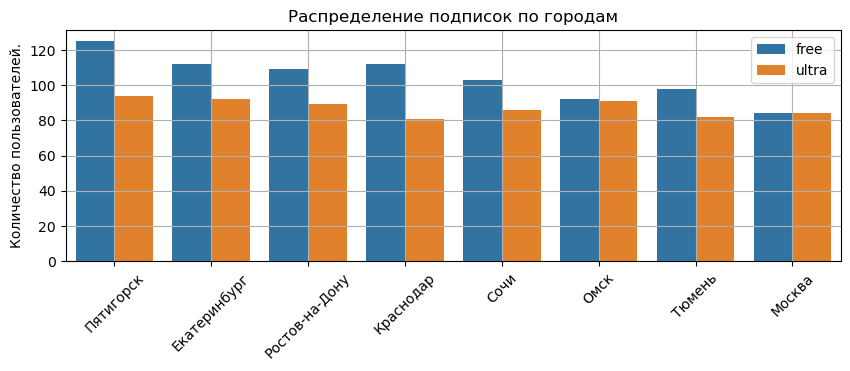

In [31]:
plt.figure(figsize=(10, 3))
# строим столбчатый график
sns.barplot(x='city', y='user_id', data=subscription_cities_count, hue='subscription_type')

#plt.yscale('log')

plt.title('Распределение подписок по городам')
plt.xlabel('')
plt.ylabel('Количество пользователей.')
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.show()

**Соотношение платных и бесплатных пользователей по городам**

In [33]:
#Рассчитаем соотношение платных и бесплатных пользователей по городам.
subscription_cities_share = users.pivot_table(index='subscription_type', columns='city', values='user_id', aggfunc='count').T

subscription_cities_share['users_total'] = subscription_cities_share['free']+subscription_cities_share['ultra']
subscription_cities_share['share_ultra'] = subscription_cities_share['ultra']/ subscription_cities_share['users_total']
subscription_cities_share = subscription_cities_share.sort_values(by='users_total', ascending=True)
subscription_cities_share

subscription_type,free,ultra,users_total,share_ultra
city,,,,
Москва,84,84,168,0.50
Тюмень,98,82,180,0.46
Омск,92,91,183,0.50
Сочи,103,86,189,0.46
Краснодар,112,81,193,0.42
Ростов-на-Дону,109,89,198,0.45
Екатеринбург,112,92,204,0.45
Пятигорск,125,94,219,0.43


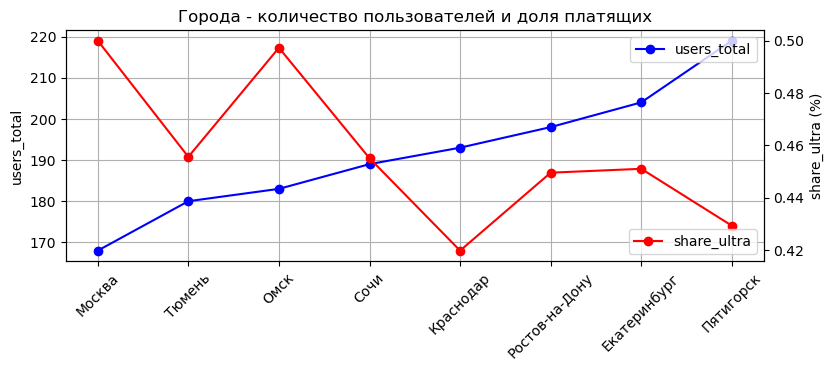

In [34]:
fig, ax1 = plt.subplots(figsize=(9, 3))

# Первая диаграмма - количество пользователей
ax1.plot(subscription_cities_share.index, subscription_cities_share['users_total'], marker='o', color='b', label='users_total')
ax1.set_xlabel('')
ax1.set_ylabel('users_total')
ax1.grid(True)
ax1.set_title('Города - количество пользователей и доля платящих')

# Поворачиваем подписи оси X на 45 градусов
ax1.set_xticks(range(len(subscription_cities_share.index)))
ax1.set_xticklabels(subscription_cities_share.index, rotation=45)

# Вторая ось Y
ax2 = ax1.twinx()

# Вторая диаграмма - доля заплативших в процентах
ax2.plot(subscription_cities_share.index, subscription_cities_share['share_ultra'], marker='o', color='r', label='share_ultra')
ax2.set_ylabel('share_ultra (%)')
ax2.grid(False)

# Настройки легенды
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.show()


**Наблюдения**

Во всех городах количество бесплатных пользователей больше, чем платных.\
За исключением Москвы, где эти количества практически равны. Но мы помним, что позиция Москвы с учвётом населения - аномальна. 

Доля платных пользователей по всем городам сопоставима - от 43 до 50 процентов.\
**С ростом количества пользователей, доля платных подписок падает**.



### Возраст пользователей

#### Распределение пользователей по возрастам

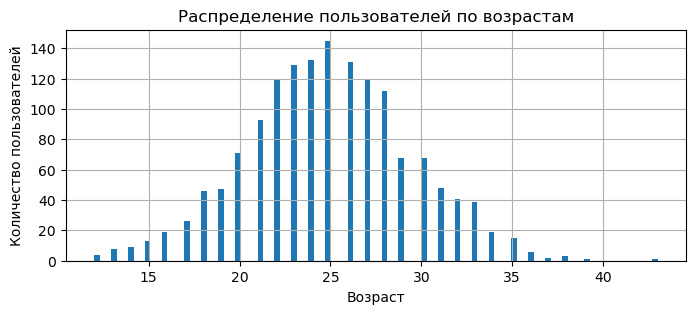

In [40]:
# Гистограмма для age в users
users['age'].hist(bins=100,figsize=(8, 3))
# Добавление заголовка, подписей осей и легенды
plt.title('Распределение пользователей по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

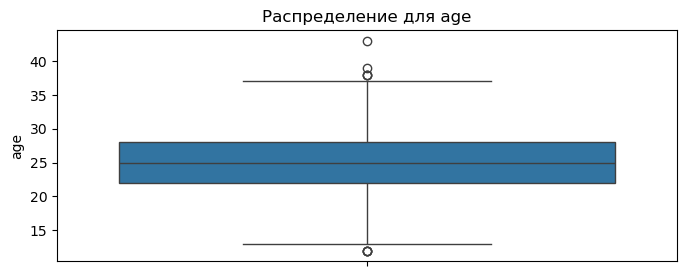

In [41]:
# Строим ящик с усами для age (других числовых столбцов в датасете нет)
plt.figure(figsize=(8, 3))
#sns.boxplot(data=users)
age_box = sns.boxplot(data=users['age'])  # Сохраняем объект оси в переменную ax

plt.title('Распределение для age')
#plt.xlabel('Возраст')
plt.show()

In [42]:
# ФУНКЦИЯ РАСЧЁТА СТАТИСТИКИ calculate_statistics

def calculate_statistics(data, column):
    # Среднее значение
    mean_value = np.mean(data[column])
    # Стандартное отклонение
    std_value = np.std(data[column], ddof=1)
    # Минимальное значение
    min_value = np.min(data[column])
    # 25-й процентиль (первая кварть)
    p25 = np.percentile(data[column], 25)
    # Медиана (50-й процентиль)
    median_value = np.percentile(data[column], 50)
    # 75-й процентиль (третья кварть)
    p75 = np.percentile(data[column], 75)
    # Максимальное значение
    max_value = np.max(data[column])
    # Межквартильный размах (IQR)
    iqr_value = stats.iqr(data[column])
    # Границы усов для ящика с усами
    lower_whisker = p25 - 1.5 * iqr_value
    upper_whisker = p75 + 1.5 * iqr_value

    # Создаём DataFrame с результатами
    result_df = pd.DataFrame({
        'Metric': ['Mean', 'Std', 'Min', 'P25', 'Median', 'P75', 'Max', 'IQR', 'Lower Whisker', 'Upper Whisker'],
        'Value': [mean_value, std_value, min_value, p25, median_value, p75, max_value, iqr_value, lower_whisker, upper_whisker]
    })

    return result_df

In [43]:
# вызаем функцию calculate_statistics
user_age_stat = calculate_statistics(users, 'age')

# Выводим таблицу с результатами
display(user_age_stat)


,Metric,Value
0,Mean,24.90
1,Std,4.57
2,Min,12.00
3,P25,22.00
4,Median,25.00
5,P75,28.00
6,Max,43.00
7,IQR,6.00
8,Lower Whisker,13.00
9,Upper Whisker,37.00


**Наблюдения**

Распределение пользоватедей по возрастам близко к стандартному.\
Половина пользователей находятся в границай 22-28 лет со стандартным отклонение 4,57 года\
Средний возраст - 24,9 лет.
Основная масса данных находится в диапазоне 13- 37 лет.
Нетипичных данных (выбросов) нет. 

#### Распределение возрастов по городам

In [47]:
# Строим таблицу (функцией group_and_sort)
age_cities_mean = group_and_sort(users, 'city', None,  'age',np.mean)
age_cities_mean

,city,age
0,Омск,25.38
1,Краснодар,25.29
2,Москва,25.27
3,Екатеринбург,24.96
4,Пятигорск,24.72
5,Тюмень,24.64
6,Ростов-на-Дону,24.55
7,Сочи,24.51


In [48]:
# Считаем стандартное отклонение
mean = age_cities_mean['age'].mean()
var = 0
for i in age_cities_mean['age']:
    var += (i - mean) * (i - mean)
var /= len(age_cities_mean['age'])
std = var**0.5 # извлекаем корень

print(f'Стандартное отклонение {round(std, 2)}')

Стандартное отклонение 0.34


**Наблюдения**

Средний возраст пользователей с расчётом по городам имеет незначительный разброс, меньше 1 года и лежит а диапазоне 24,51 - 25.38 лет.\
Так как суммарные данные по всем городам имеют стандартное распределение, группируются вокруг среднего значения 24,9 с отклонением всего 0,34 года, то **делать разбивку возрастов по городам представляется не целесообразным**.   

#### Распределение подписок по возрастам

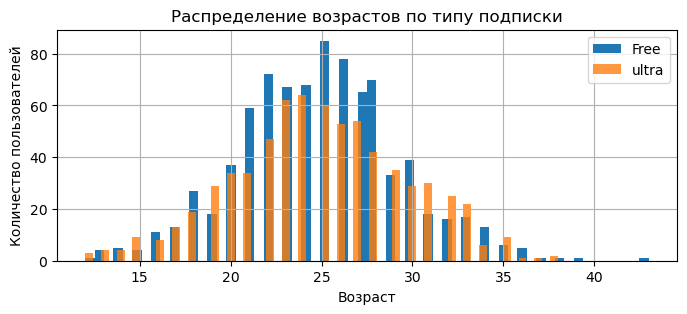

In [52]:
# Раpделяем данные и строим гистограммы
filtered_free = users.query("subscription_type == 'free'")
filtered_ultra = users.query("subscription_type == 'ultra'")

filtered_free['age'].hist(bins=60,figsize=(8, 3), label='Free');
filtered_ultra['age'].hist(bins=60,figsize=(8, 3), alpha=0.8, label='ultra')

# Добавление заголовка, подписей осей и легенды
plt.title('Распределение возрастов по типу подписки')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.legend(loc='upper right')
plt.show()

Распределение пользователей по возрастам в том и другом виде подписок имеет различие.\
Посмотрим, в чём оно заключается.

**Исследуем параметры распределения в той и другой группе**

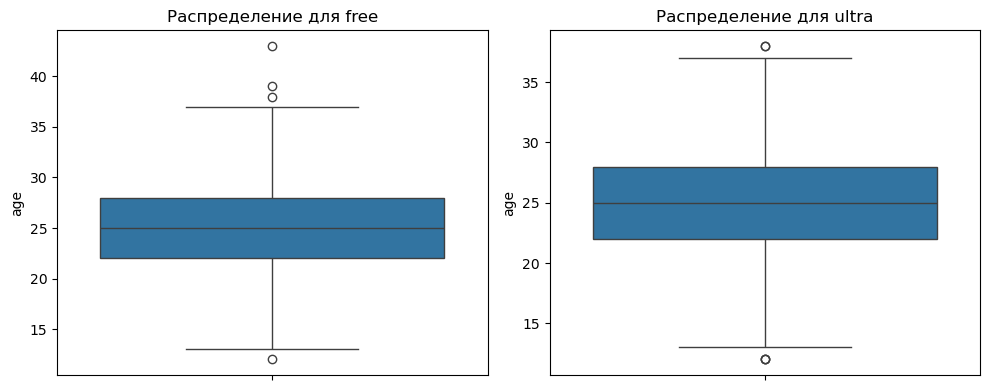

In [55]:
# Создаем фигуру с двумя подграфиками
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Первый ящик с усами (например, для возраста)
age_dox_free = sns.boxplot(data=filtered_free, y='age', ax=ax[0])
ax[0].set_title('Распределение для free')

# Второй ящик с усами (например, для другого параметра, например, города)
age_dox_ultra = sns.boxplot(data=filtered_ultra, y='age', ax=ax[1])
ax[1].set_title('Распределение для ultra')

plt.tight_layout()  # Подгоняем расположение графиков
plt.show()

#age_box = sns.boxplot(data=users['age'])

In [56]:
# вызаем функцию calculate_statistics для filtered_free
age_free_stat = calculate_statistics(filtered_free, 'age')

# вызаем функцию calculate_statistics для filtered_ultra
age_ultra_stat = calculate_statistics(filtered_ultra, 'age')

# Объединяем
age_free_ultra_stat = age_free_stat.merge(age_ultra_stat, on = 'Metric', how = 'left')
# Переименовываем столбцы в более логичные
age_free_ultra_stat = age_free_ultra_stat.rename(columns={'Value_x': 'Value_free',
                                                'Value_y': 'Value_ultra'})

# Выводим таблицу с результатами
print ('age stat')
display(age_free_ultra_stat)


age stat


,Metric,Value_free,Value_ultra
0,Mean,24.87,24.94
1,Std,4.43,4.74
2,Min,12.00,12.00
3,P25,22.00,22.00
4,Median,25.00,25.00
5,P75,28.00,28.00
6,Max,43.00,38.00
7,IQR,6.00,6.00
8,Lower Whisker,13.00,13.00
9,Upper Whisker,37.00,37.00


**Наблюдения**

Распределение платных и бесплатных подписок во многом схоже.\
Различие в стандартном отклонении 4,43 у бесплатных и  4,74 у платных, показвает более равномерное распределение платных подписок по возрастам.\
И в той и в другой группе наибольшаое количество пользователей сосредоточено в возрастном диапазоне 22-28 лет.

На совмещйнной гистограмме видно, что:
- **в диапазоне наиболее активных возрастов, составляющищих 50% всех польльзователей - 22-28 лет - бесплатные пользователи преобладают**,
-  в группе от 29 лет - преобладают платные подписки.

### Расстояние, которое пользователь преодолел за одну поездку

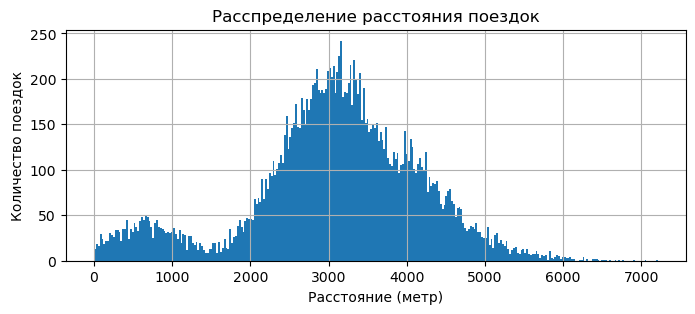

In [61]:
# Гистограмма для distance в rides
rides['distance'].hist(bins=300,figsize=(8, 3))
# Добавление заголовка, подписей осей и легенды
plt.title('Расспределение расстояния поездок')
plt.xlabel('Расстояние (метр)')
plt.ylabel('Количество поездок')
plt.show()

In [62]:
#distance_box = sns.boxplot(data=rides['distance'])
#distance_box

In [63]:
# вызаем функцию calculate_statistic
distance_stat = calculate_statistics(rides, 'distance')

# Выводим таблицу с результатами
display(distance_stat)


,Metric,Value
0,Mean,3070.66
1,Std,1116.83
2,Min,0.86
3,P25,2543.23
4,Median,3133.61
5,P75,3776.22
6,Max,7211.01
7,IQR,1233.00
8,Lower Whisker,693.73
9,Upper Whisker,5625.72


Мы получили гистограмму с неравномерностью в области 0-1500 м.
>Можно предполодить, что сегмент "Короткие поездки" стоит выделить как самостоятельный.
>Проверим это предположение, выяснив - этот феномен свойственнен всем городам, или мы имеем дело с влиянием какого-то одного города.\
>Для этого **сравним показатель средней дистанции по городам с полученным общим средним**.\
>Если средние значения будут сильно отличаться друг от друга и от общего среднего, то феномен зависит от города.\
>**Если разница будет невелика, то данное распределение в той или иной форме можно обнаружить в лбьом городе**.

In [65]:
# Строим таблицу
rides_n_cities = rides.merge(users, on = 'user_id', how = 'left')

distance_cities_mean = group_and_sort(rides_n_cities, 'city', None,  'distance',np.mean)
distance_cities_mean['diff_mean'] = (distance_cities_mean['distance'].mean() - distance_cities_mean ['distance'])*(-1)
distance_cities_mean['diff_share_%'] = distance_cities_mean['diff_mean'] / distance_cities_mean ['distance']*100
print (f'Общее среднее расстояние поездок с учётом округлений: {round(distance_cities_mean["distance"].mean(),2)}')

distance_cities_mean

Общее среднее расстояние поездок с учётом округлений: 3070.53


,city,distance,diff_mean,diff_share_%
0,Пятигорск,3118.68,48.14,1.54
1,Екатеринбург,3110.91,40.38,1.30
2,Москва,3101.00,30.46,0.98
3,Тюмень,3076.24,5.71,0.19
4,Краснодар,3054.30,-16.24,-0.53
5,Сочи,3052.96,-17.57,-0.58
6,Омск,3038.68,-31.85,-1.05
7,Ростов-на-Дону,3011.51,-59.03,-1.96


**Наблюдения**

Средние дистанции по городам очень близки. Их отличие от общего среднего не превышает 2 процентов.

**Вывод**:
- Полученное распределение с особой группой коротких поездок характерно для всех городов.
- Целесообразно выделить группу "Короткие поездки" в отдельную категорию.

### Продолжительность поездок

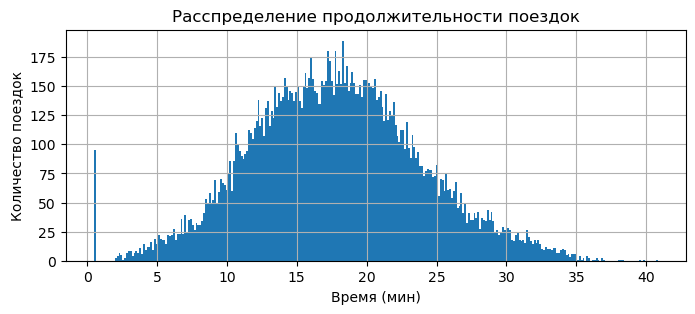

In [69]:
# Гистограмма для duration в rides
rides['duration'].hist(bins=300,figsize=(8, 3))
# Добавление заголовка, подписей осей и легенды
plt.title('Расспределение продолжительности поездок')
plt.xlabel('Время (мин)')
plt.ylabel('Количество поездок')
plt.show()

Обращает на себя внимание пик в районе меньше 1 минуты.\
**Проверим, есть ли он во всех городах и в каком количестве**.\
Для отого отфильтруем из объединённой таблицы поездки меньше 1 минуты.

In [71]:
duration_min = rides_n_cities.query('duration < 1.0')

duration_min_cities = group_and_sort(duration_min, 'city', 'subscription_type',  'user_id',np.size)
duration_min_cities

,city,subscription_type,user_id
0,Ростов-на-Дону,free,17
1,Москва,free,14
2,Пятигорск,free,13
3,Омск,free,11
4,Сочи,free,11
5,Краснодар,free,10
6,Тюмень,free,10
7,Екатеринбург,free,9


Поездки меньше 1 минуты есть во всех городах и всегда это - бесплатная подписка.

**Рассмотрим подробнее поездки не превышающие 1 минуту**

In [74]:
# Посмотрим на дистанции поездок меньше 1 минуту
duration_min_cities = group_and_sort(duration_min, 'city', 'subscription_type',  'distance',np.median)
duration_min_cities

,city,subscription_type,distance
0,Сочи,free,5409.75
1,Пятигорск,free,5353.19
2,Москва,free,5146.43
3,Екатеринбург,free,5071.58
4,Ростов-на-Дону,free,4881.39
5,Тюмень,free,4856.42
6,Омск,free,4835.93
7,Краснодар,free,4737.04


In [75]:
# Посмотрим на распределение по месяцам поездок меньше 1 минуту
duration_min_cities = group_and_sort(duration_min, 'month', None,  'distance',np.size)
duration_min_cities.sort_values('month')

,month,distance
3,1,9
4,2,8
0,3,11
7,4,7
5,5,8
10,6,5
8,7,7
6,8,8
9,9,6
11,10,4


Дистанция поездок меньше 1 минуты по всем городам в районе 5 км. Также они присутствуют в каждом месяце. Но в малом количестве.\
Вполне вероятно, что это бонусные поездки по фиксированной цене, равной эквиваленту 1 минте.
>Малое количенство и присутствие во всех месяцах можно считать результатом сценария маркетинговой акции в котором (предположим) бонусную первую поездку получает каждый N польхователь.\
> Для самого же пользователя получение такой поездки равноценно случайному выигрышу.

**Представляется правильным их удалить**, так как в данном случае мы не знаем сценарий акции, и её экономику.

In [77]:
# Удаляем сверх-короткие поездки
rides_n_cities = rides_n_cities.query ('duration >= 1').reset_index(drop=True)
#rides_n_cities

Выводим статистику после удаления строк.

In [79]:
rides_n_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(3)
memory usage: 1.2+ MB


Удалены 85 строк (18068-17973). Что соответствует нашей гистограмме.

In [81]:
# вызаем функцию calculate_statistic
duration_stat = calculate_statistics(rides_n_cities, 'duration')

# Выводим таблицу с результатами
display(duration_stat)

,Metric,Value
0,Mean,17.90
1,Std,5.98
2,Min,2.04
3,P25,13.67
4,Median,17.71
5,P75,21.75
6,Max,40.82
7,IQR,8.08
8,Lower Whisker,1.56
9,Upper Whisker,33.86


**Наблюдения**

1) Среднее время понздки 17,9 минуты.\
   50% поездок находятся в диапазоне 13.67 - 21.75 минуты.\
   При этом разброс времени поездок высок - диапазон основного массива данных - от 1,56 до почти 34 минут.

2) На гистограмме распределения времени нет неравномерности в районе коротких по времени поездок, которая бы кореллировала с неравномерностью в области коротких по расстоянию поездок.
   >Эта особенность может быть объяснена тем, что прямой связи между расстоянием и временем нет.
   > Время поездки зависит не только от расстояния, но и от скорости движения, на которую влияют многие внешние факторы.

##  Объединение датасетов

### Объединение и добавление категоризации

План:
- Объединяем датасеты в один.
- Вводим категоризацию по расстоянию (см. п.4.4 "Продолжительность поездок").
- Разделяем датасет на 2 части по типу подписки.
- Визуализируем данные о расстоянии и времени поездок для каждого вида подписок.

In [88]:
# Так как 2 датасета мы уже объединили раньше, то добавляем третий датасет
data_total = rides_n_cities.merge(subscriptions, on = 'subscription_type', how = 'left')

# Вводим категоризацию по дистанции
def categorize_distance(distance):
    try:
        if 0 <= distance < 1500:
            return 'Малое расстояние'
        else:
            return 'Стандартное расстояние'
    except TypeError:
        return 'None'
# Категоризация
data_total['distance_bin'] = data_total['distance'].apply(categorize_distance)

# Проверяем результат
#display (data_total.sample(3))
data_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int32         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
 12  distance_bin       17973 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(

В объединённой таблице 17973 записи. Столько же в самом большом из объединяемых датасетов rides_n_cities.\
Пропусков в объединённой таблице нет.

### Исследование коротких по расстоянию поездок. 

In [91]:
# Посмотрим на распределение поездок по категориям расстояния distance_bin
print (data_total['distance_bin'].value_counts())

distance_bin
Стандартное расстояние    16177
Малое расстояние           1796
Name: count, dtype: int64


Изучим короткие поездки. В каждом ли месяце есть такие поездки и в каждом ли виде подписки.

In [93]:
# Выделим Короткие поезжки
short_distance = data_total.query("distance <= 1500")

In [94]:
short_distance_month = group_and_sort(short_distance, 'subscription_type', 'month',  'distance',np.size)
# Переименовываем столбцы в более логичные
short_distance_month = short_distance_month.rename(columns={'distance': 'distance_count'})
short_distance_month

,subscription_type,month,distance_count
0,free,1,108
1,free,2,106
2,free,3,130
3,free,4,107
4,free,5,96
5,free,6,104
6,free,7,98
7,free,8,127
8,free,9,106
9,free,10,117


**Наблюдения**\
Более 10 % поездок это - поездки на малые расстояния, не более 1,5 км при средней дальности более 3 км (3070 м)

Поездки на короткие расстояния (до 1,5 км) есть во всех городах и в каждом месяце года.\
как у платных, так и у бесплатных пользователей.

**Возможное объяснение**
Так как это явление не зависит от подписки, географии, времени, то, видимо, это эффект технический.\
И вызван запасом хода батареи в момент активации поездки.\
Если бы батарея была вечной, то этого пика бы не было и хвост был бы равномерный.
> Мы ищем ответ **уже имея данные о распределении поездок в засисимости от подписки и рассчё, того, что короткие поездки составляют 10% общего объёма**.\
> Поэтому можем дополнить предположение следующим - 10% это именно те случаи, когда пользователь не смотрит заранее на остаток заряда (хода) перед активацией поездки, либо считает, что ему достаточно.\
> Платные пользователи, естественно, более ответсвенны и более внимательны к этой информации - этим можно объяснить смещение дистанции сегмента коротких поездок (это будет проиллюстрировано в дальнейшем) в большую сторону.

### Разделение объединённого датасета по видам подписки

In [99]:
# Вводим две новые переменные и разделяем датасет
data_free = data_total.query("subscription_type == 'free'")
data_ultra = data_total.query("subscription_type == 'ultra'")

# Проверяем результат
#display (data_free.sample(3))
#display (data_ultra.sample(3))

### Дополнительные визуализации данных

Выше, в разделе Исследовательский анализ данных, уже были визуализированы данные с разбивкой по видам подписки:
- пользователи с подпиской и без с разбивкой по городам,
- распределение подписок по возрастам.

**Дополним исследование визуализациями**:
- распределение расстояния в зависимости от видов подписки.
- распределение времени поездки в зависимости от видов подписки.

#### Распределение расстояния поездок

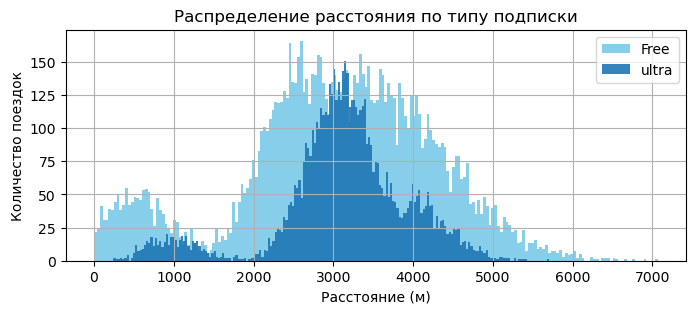

In [103]:
# Строим гистограммы
data_free['distance'].hist(bins=200,figsize=(8, 3), label='Free', color='skyblue');
data_ultra['distance'].hist(bins=200,figsize=(8, 3), alpha=0.9,  label='ultra')

# Добавление заголовка, подписей осей и легенды
plt.title('Распределение расстояния по типу подписки')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.legend(loc='upper right')
plt.show()

In [104]:
# вызаем функцию calculate_statistics для data_free
distance_free_stat = calculate_statistics(data_free, 'distance')

# вызаем функцию calculate_statistics для data_ultra
distance_ultra_stat = calculate_statistics(data_ultra, 'distance')

# Объединяем
distance_free_ultra_stat = distance_free_stat.merge(distance_ultra_stat, on = 'Metric', how = 'left')
# Переименовываем столбцы в более логичные
distance_free_ultra_stat = distance_free_ultra_stat.rename(columns={'Value_x': 'Value_free',
                                                'Value_y': 'Value_ultra'})

# Выводим таблицу с результатами
print ('distance stat')
display(distance_free_ultra_stat)


distance stat


,Metric,Value_free,Value_ultra
0,Mean,3028.37,3115.45
1,Std,1235.54,836.90
2,Min,0.86,244.21
3,P25,2360.88,2785.44
4,Median,3102.08,3148.64
5,P75,3883.98,3560.57
6,Max,7066.00,5699.77
7,IQR,1523.10,775.13
8,Lower Whisker,76.23,1622.75
9,Upper Whisker,6168.63,4723.27


**Наблюдения**
- Среднии и медианные расстояния у двух видов пользователей практически равны.
- Максимальное расстояние больше в бесплатной группе.
- Но разброс значений в платной группе заметно меньше.\
  Значение более близки к среднему, меньше коротких поездок и нет пробных (близких к нулю
  >И если левая часть графика легко объяснима наличием абонентской платы, то правая требует детальной проработки маркетологами - почему **при наличии платного абонемента, пользователи не увеличивают дальность поездок, а уменьшают её**, что видно при сравнении метрик Max и Upper Whisker в таблице статистики.

#### Распределение времени поездок

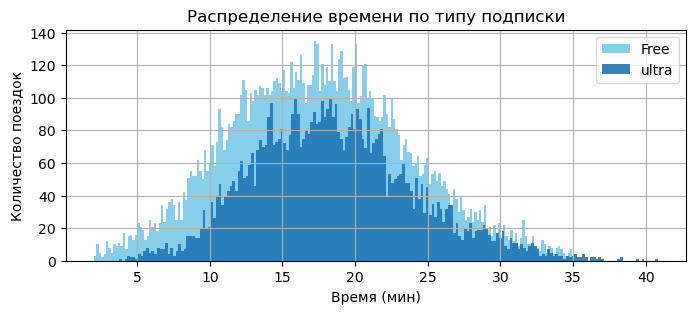

In [108]:
# Строим гистограммы
data_free['duration'].hist(bins=200,figsize=(8, 3), label='Free', color='skyblue');
data_ultra['duration'].hist(bins=200,figsize=(8, 3), alpha=0.9, label='ultra')

# Добавление заголовка, подписей осей и легенды
plt.title('Распределение времени по типу подписки')
plt.xlabel('Время (мин)')
plt.ylabel('Количество поездок')
plt.legend(loc='upper right')
plt.show()

In [109]:
# вызаем функцию calculate_statistics для data_free
duration_free_stat = calculate_statistics(data_free, 'duration')

# вызаем функцию calculate_statistics для data_ultra
duration_ultra_stat = calculate_statistics(data_ultra, 'duration')

# Объединяем
duration_free_ultra_stat = duration_free_stat.merge(duration_ultra_stat, on = 'Metric', how = 'left')

# Переименовываем столбцы в более логичные
duration_free_ultra_stat = duration_free_ultra_stat.rename(columns={'Value_x': 'Value_free',
                                                'Value_y': 'Value_ultra'})
# Добавляем столбец отношения
duration_free_ultra_stat['Delta_free_ultra'] = (
    duration_free_ultra_stat['Value_ultra'] / duration_free_ultra_stat['Value_free']
    )
# Выводим таблицу с результатами
print ('duration stat')
display(duration_free_ultra_stat)

duration stat


,Metric,Value_free,Value_ultra,Delta_free_ultra
0,Mean,17.53,18.54,1.06
1,Std,6.16,5.57,0.90
2,Min,2.04,3.76,1.85
3,P25,13.09,14.52,1.11
4,Median,17.38,18.18,1.05
5,P75,21.64,21.88,1.01
6,Max,34.95,40.82,1.17
7,IQR,8.55,7.36,0.86
8,Lower Whisker,0.26,3.49,13.55
9,Upper Whisker,34.47,32.92,0.96


**Наблюдения и предварительные выводы**
- Минимальное время поездки с подпиской на 85% больше.
- Среднее время и медиана также больше у платных пользователей на 6 и на 5 процентов соответсенно.
- Максимальное значение времени у платных также больше - на 17%.
- И хотя бесплатные пользователи имеют более высокую границу значимых данных (без учёта выбросов), Данные о платных подписках имеют меньший разброс и лучше сгруппированы вокруг среднего значения.

**Верны ли предварительные выводы или они - результата статистической ошибки или случайного колебания данных в выборке, проверим на этапе проверки гипотез**.

## Исследование выручки

### Агрегирование данных по пользователям

In [114]:
# Округляем длительность поездок до верхнего целого (потолка)
data_total['duration'] = np.ceil(data_total['duration'])

user_profiles = data_total.pivot_table (index = ['user_id', 'month','subscription_type'],
                values=['date', 'distance', 'duration'],
                aggfunc= {'date':'count', 'distance':'sum', 'duration':'sum'})

# Переименовываем столбцы в более логичные
user_profiles = user_profiles.rename(
    columns={'date': 'rides_count_m', 'distance': 'distance_m', 'duration': 'duration_m' })
user_profiles = pd.DataFrame(user_profiles).reset_index()

display(user_profiles.sample(3))

,user_id,month,subscription_type,rides_count_m,distance_m,duration_m
7684,1092,10,free,1,2086.31,20.00
8761,1223,10,free,1,3631.71,17.00
4084,623,9,ultra,1,3099.61,26.00


### Расчёт выручки

In [116]:
# Добавляем необходимые данные
add_data = data_total[['user_id','minute_price','start_ride_price', 'subscription_fee']].pivot_table (index = 'user_id')

user_profiles_rev = user_profiles.merge(
                       add_data, on = 'user_id', how = 'left')

# Добавляем столбец с выручкой
user_profiles_rev['month_revenue'] = (
            user_profiles_rev['start_ride_price'] * user_profiles_rev['rides_count_m']) + (
                user_profiles_rev['minute_price'] * user_profiles_rev['duration_m']
                     ) + user_profiles_rev['subscription_fee']

user_profiles_rev.sample(3)

,user_id,month,subscription_type,rides_count_m,distance_m,duration_m,minute_price,start_ride_price,subscription_fee,month_revenue
1648,251,8,ultra,1,4085.26,14.00,6.00,0.00,199.00,283.00
3266,502,2,ultra,1,3431.62,21.00,6.00,0.00,199.00,325.00
5694,847,11,free,1,4021.30,23.00,8.00,50.00,0.00,234.00


**Итог**:\
Создана таблица профилей клиентов и добавлен расчёт ежемесячной выручки от каждого клиента.

## Проверка гипотез

### Гипотеза 1. Вид подписки и время поездок.

**Пользователи с подпиской тратят больше времени на поездки**.
>Если да, то пользователи с подпиской могут быть более выгодными для компании.

**Нулевая гипотеза**:\
Среднее время поездок с подпиской равно среднему времени поездок без подписки.\
**Альтернативная гипотеза**:\
Среднее ремя с подпиской больше среднего времени без подписок.

In [122]:
# Проверяем гипотезу
# уровень статистической значимости 0.05
alpha = 0.05 

results = stats.ttest_ind(
    data_ultra['duration'], 
    data_free['duration'],  alternative= 'greater', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Среднее время с подпиской больше среднего времени без подписки')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Среднее время с подпиской не больше среднего без подписки')


p-значение: 1.6162210195311066e-29
Отвергаем нулевую гипотезу. Среднее время с подпиской больше среднего времени без подписки


**Тест подтверждает альтернативную гипотезу**.
Позьзователи с подпиской тратят больше временин на поездки, чем пользователи без подписки.\
Это позволяет утверждать, что пердварительные выводы, сделанные ранее на основе визуализации и статистики, обоснованы и не являются статистической ошибкой.
>Повторим их:
>- Минимальное время поездки с подпиской на 85% больше.
>- Среднее время и медиана также больше у платных пользователей на 6 и на 5 процентов соответсенно.
.- Максимальное значение времени у платных также больше - на 17%
>- И хотя бесплатные пользователи имеют более высокую границу значимых данных (без учёта выбросов), данные о платных подписках имеют меньший разброс и лучше сгруппированы вокруг среднего значения.

**Более высокие показатели длительности поездок по подписокам\
не означают автоматически, что они более выгодны для компании**.\
Большая длительность использования самокатов может быть нивелирована более низкой средней стоимостью минуты поездки.

Проверим это.

У нас уже есть таблица с выручкой по месяцам. Используем её.

In [126]:
free_ultra_rev_grouped = user_profiles_rev.pivot_table(index = 'subscription_type',
                values=['duration_m', 'month_revenue'],
                aggfunc= {'duration_m':'sum', 'month_revenue':'sum'})
free_ultra_rev_grouped['real_profit_minute'] = free_ultra_rev_grouped['month_revenue'] / free_ultra_rev_grouped['duration_m']

# Переименовываем столбцы в более логичные
free_ultra_rev_grouped = free_ultra_rev_grouped.rename(columns={'duration_m': 'duration_ttl',
                                'month_revenue': 'revenue_ttl'})
free_ultra_rev_grouped

,duration_ttl,revenue_ttl,real_profit_minute
subscription_type,,,
free,206868.00,2228594.00,10.77
ultra,123745.00,1644537.00,13.29


**Наблюдение**\
У платных пользователей не только время поездок выше, чем у бесплатных.\
Но и, в соответствии с ретроспективными данными, - доходность 1 минуты ultra - выше почти на 30%, чем free.

### Гипотеза 2. Оптимальное расстояние - 3130 м

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.\
Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

**Нулевая гипотеза**:\
Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров.\
**Альтернативная гипотеза**:\
Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 метров..

In [131]:
# Проверяем гипотезу
# Срасстояние, которое проезжают пользователи с подпиской за одну поездку
interested_value = 3130

# уровень статистической значимости 0.05
alpha = 0.05 

results = stats.ttest_1samp(
    data_ultra['distance'], 
    interested_value, alternative= 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Среднее расстояние поездки с подпиской больше 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Среднее расстояние поездки с подпиской не больше 3130 метров')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу. Среднее расстояние поездки с подпиской не больше 3130 метров


**Результат t-test для ultra**:\
среднее расстояние поездки с подпиской не превышает 3130 метров.

**Сделаем такую же проверку для пользователей free**

In [134]:
# Проверяем гипотезу
# Срасстояние, которое проезжают пользователи с подпиской за одну поездку
interested_value = 3130

# уровень статистической значимости 0.05
alpha = 0.05 

results = stats.ttest_1samp(
    data_free['distance'], 
    interested_value, alternative= 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Среднее расстояние бесплатных поездок больше 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Среднее расстояние ьесплатных поездок не больше 3130 метров')

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу. Среднее расстояние ьесплатных поездок не больше 3130 метров


**Результат t-test для free**:\
среднее расстояние поездки без подписки не больше 3130 метров.

**Вывод**\
Среднее расстояние поездок как ultra, так и free не выше максимального с точки зрения износа самоката.

### Гипотеза 3. Вид подписки и выручка.

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Нулевая гипотеза**:\
Выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.\
**Альтернативная гипотеза**:\
выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [140]:
# Делим таблицу с помесячной выручкой на 2 части по виду подписки
month_rev_free = user_profiles_rev.query("subscription_type == 'free'")
month_rev_ultra = user_profiles_rev.query("subscription_type == 'ultra'")

In [141]:
# Проверяем гипотезу
# уровень статистической значимости 0.05
alpha = 0.05 

results = stats.ttest_ind(
    month_rev_ultra['month_revenue'], 
    month_rev_free['month_revenue'], alternative= 'greater', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки.')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Выручка от пользователей с подпиской по месяцам не больше выручкт от пользователей без подписки.')

p-значение: 2.497024287285847e-38
Отвергаем нулевую гипотезу. Выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки.


**Результат t-test**:\
Выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки.

## Заключение и выводы

### Исследование данных в датасете

1) Чаще всего в системе регистрируются пользователи из Пятигорска (14.28 %), реже всего - из Москвы (10,95 %).
Разница составляет 3,33 %. На первй взгляд, не много, но Москва по численности потенциальных пользователей в десятки раз больше Пятигорска. Следовательно, положение Москвы по данному показателю очень низкое.
>Возможно, это связано или с низкой доступностью сервиса в Москве, или с завышенной стоимостью услуги в городе.

2) Во всех городах количество бесплатных пользователей больше, чем платных.
За исключением Москвы, где эти количества практически равны, но позиция Москвы с учвётом населения - аномальна.\
Доля платных пользователей по всем городам сопоставима - от 43 до 50 процентов.
С ростом количества пользователей, доля платных подписок падает.

3) Средний возраст пользователей - 24,9 лет.
Основная масса данных находится в диапазоне 13- 37 лет.

4) В диапазоне наиболее активных возрастов, составляющищих 50% всех польльзователей - 22-28 лет - бесплатные пользователи преобладают. В группе от 29 лет - преобладают платные подписки.

5) График продолжительности поездок имеет неравномерность в области 0-1500 м.\
   Более 10 % поездок это - поездки на малые расстояния, не более 1,5 км при средней дальности более 3 км (3070 м)
Такое распределение с особой группой коротких поездок характерно для всех городов.

>**Рекомендация**\
>Можно предложить маркетологам выделить сегмент "Короткие поездки" как самостоятельный.\
>И разработать меры по его уменьщению. Предложения - в следующем разделе.

6) Среднее время понздки 17,9 минуты. 50% поездок находятся в диапазоне 13.67 - 21.75 минуты.
   
8) Сравнение проезжаемого расстояния от вида подписки показало:
   - Среднии и медианные расстояния у двух видов пользователей практически равны.
   - -Максимальное расстояние больше в бесплатной группе.
   - Но разброс значений в платной группе заметно меньше.
> Cмещение малых расстояний в сторону увеличения у платных подписок вполне объяснимо фактом наличия абонентской платы. Но почему при наличии платного абонемента, пользователи не увеличивают дальность поездок, а уменьшают её - этот факт требует отдельного исследования. 

### Результаты проверки гипотез

1) Позьзователи с подпиской тратят больше временин на поездки, чем пользователи без подписки.\
   t-test подтвердил, что пердварительные выводы, сделанные на основе визуализации и статистики, обоснованы и не являются статистической ошибкой.
   - Минимальное время поездки с подпиской на 85% больше.
   - Среднее время и медиана также больше у платных пользователей на 6 и на 5 процентов соответсенно.
   - Максимальное значение времени у платных также больше - на 17%
   - У платных пользователей не только время поездок выше, но и, в соответствии с имеющимися данными, доходность 1 минуты ultra - выше почти на 30%, чем free.


2) Среднее расстояние поездки как с подпиской, так и без не превышает оптимальных с точки зрения износа  3130 метров.


4) Выручка от пользователей с подпиской в рассчёте по месяцам больше выручки от пользователей без подписки.

> **Рекомендации**\
> Развитие группы платных подписок переспективно для компании.\
> Также можно рекоменловать:
> - разработать меры по уменьшению количества коротких по расстоянию поездок. Если наше предположение об исчерпаемости батареи верно, то уменьшить количество таких поездок можно переключив выбор пользователя на более заряженные экземпляры. Вероятно стоит переработать систему информирования.
> - принять тарифные меры для компенсации износа самокатов больше оптимального у платных пользователей при дальних поездках.
>    >Мы видели, что средняя дистанция не превышает критическую точку. Но это - среднее значение. Половина самокатов проходят большее расстояние.
> - Также целесообразно ограничить дистанцию для категории free. Например, введя тариф без абонентской платы, но с ограничением по дистанции.
> - Обратить внимание на Москву, представленность которой в датасете непропорциональна количеству населения. Если это не особенности выборки, то стоит приложить усилия к развивитию сервиса в городе.

